In [8]:
import numpy as np, pandas as pd
import lightgbm as lgb
import sklearn, sys
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, average_precision_score
from sklearn.model_selection import train_test_split

print(sys.version)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
import lightgbm as lgbm  # or import xgboost as xgb if you installed that
print("OK")


3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
numpy: 2.2.6
pandas: 2.3.1
sklearn: 1.7.1
OK


In [9]:
#SESSION 1 (Setup + baseline)

#Point to SECOM folder
data_dir = Path(r"C:\Users\conor\Projects\quality-risk1\data")
X_path = data_dir / "secom.data"
y_path = data_dir / "secom_labels.data"


# Features are whitespace-separated; many NaNs are the string "NaN"
# Labels file has two columns: class (-1/1) and a timestamp
X = pd.read_csv(X_path, sep=r"\s+", header=None, na_values=["NaN"])
y_df = pd.read_csv(y_path, sep=r"\s+", header=None, names=["label", "timestamp"])

assert len(X) == len(y_df), f"Row mismatch: X={len(X)} labels={len(y_df)}"
X.columns = [f"f{i}" for i in range(X.shape[1])]   # 591 feature names
y = (y_df["label"] == 1).astype(int)               # map {-1,1} -> {0,1} (1 = positive)

# Train/test split
# Splits the data into training data (X_tr and y_tr) and test data(X_te,y_te). This does it at a 25% split. The stratify command ensures that the distribution of y is approximately equal in the test and training data.
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42
)

# Sanity prints
# Overall Dimensions of X data
print("X shape:", X.shape) 
# Overall Dimensions of X training and test data, respectively
print("Train:", X_tr.shape, " Test:", X_te.shape) 
# Incidence of Positives in y, in the total, training, and test data, respectively
print("Positive rate (overall, train, test):",y.mean().round(3), y_tr.mean().round(3), y_te.mean().round(3))
# Check for empty columns
print("Columns all-NaN:", int(X.isna().all(axis=0).sum()))
#Give an idea of sparsity
print("Median missing per column:", X.isna().mean().median().round(3))


X shape: (1567, 590)
Train: (1175, 590)  Test: (392, 590)
Positive rate (overall, train, test): 0.066 0.066 0.066
Columns all-NaN: 0
Median missing per column: 0.004


In [10]:
# Quick analysis of Emptiness of the remaining training data
def nan_report(X: pd.DataFrame, missing_tokens=("NaN",)) -> pd.DataFrame:
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be a pandas DataFrame")

    # Mask real NaNs
    mask = X.isna()

    # Also treat specified literal tokens as missing (e.g., "NaN")
    for tok in missing_tokens or ():
        mask |= (X == tok)

    counts = mask.sum(axis=0)
    denom = len(X) if len(X) else 1
    rates = counts / denom

    order = rates.sort_values(ascending=False).index
    out = pd.DataFrame(
        [counts[order].to_numpy(), rates[order].to_numpy()],
        index=["nan_count", "nan_rate"],
        columns=order,
    )
    return out

nan_report(X)

,f292,f293,f158,f157,f492,f85,f358,f220,f244,f517,...,f114,f113,f527,f526,f524,f523,f522,f521,f520,f120
nan_count,1429.000000,1429.000000,1429.000000,1429.000000,1341.000000,1341.000000,1341.000000,1341.000000,1018.000000,1018.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nan_rate,0.911934,0.911934,0.911934,0.911934,0.855775,0.855775,0.855775,0.855775,0.649649,0.649649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Drop columns that are entirely NaN
all_nan = X_tr.columns[X_tr.isna().all()]
X_tr = X_tr.drop(columns=all_nan)
X_te = X_te.drop(columns=all_nan)

# Also drop zero-variance columns (if any)
nunique = X_tr.nunique()
zero_var = nunique[nunique <= 1].index
X_tr = X_tr.drop(columns=zero_var)
X_te = X_te.drop(columns=zero_var)

print(f"Dropped {len(all_nan)} all-NaN cols, {len(zero_var)} zero-variance cols.")
print("Train/Test shapes:", X_tr.shape, X_te.shape)


Dropped 0 all-NaN cols, 116 zero-variance cols.
Train/Test shapes: (1175, 474) (392, 474)


In [12]:
#SESSION 2 (First Models)

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
# A function to evaluate the PR and ROC of a given model, with a fixed threshold of .5. Later, this threshold will be optimized. 
# y_true is the actual score of some test data, proba is the predicted probabilities that the test data should be given a score of 1

# On Precision and Recall. This is all computed at a certain threshold value, t, where a probability of p is counted as a score of 1 iff p>t. 
# Precision: Ratio of True Positives over total flagged positives. That is to say, it gives you the probability that something should have been flagged, given we flagged it.
# Recall: Ratio of True Positives over total actual positives. That is to say, it gives you the probability that you successfully flag something that should be flagged.
# Since both of these depend on our threshold, we can regard these as two a curve over [0,1], given by (P(t),R(t)), called the PR Curve
def evaluate(y_true, proba, name="model"):
    # ROC-AUC: P(score of a random positive > score of a random negative), Less useful for our data due to our low positive rate (i.e can give a
    roc = roc_auc_score(y_true, proba)
    # PR-AUC: Gives the average precision across all threshold values, that is to say, the area under the PR curve.
    pr  = average_precision_score(y_true, proba)
    
    pred = (proba >= 0.5).astype(int)             

    # Outputs a little summary of the models scores.
    print(f"{name} -> ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")
    print(classification_report(y_true, pred, digits=3,zero_division=0))
    return {"roc_auc": roc, "pr_auc": pr}


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# A Logistic Regression model.
# Overall, the Pipeline function takes a series of steps on our data. So logit is a series of commands that we will feed some training data to.
# Impute - Fill in missing values wit median
# Scale  - Rescales each column of X (each feature) so that they have mean 0 and deviation 1. As this algorithm penalizes based on an L2 norm, large parameter gap values would otherwise be overemphasized. The fact that with_mean=false says not to set the mean to 0,
#          and just rescaled by the deviation. Probably not too important in a sparse & high-dimensional setting.
# CLF    - The actual classifier which takes this data and returns estimators, in this case using logistic regression.
logit = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median", add_indicator=True)),
    ("scale",  StandardScaler(with_mean=False)), 
    ("clf",    LogisticRegression(max_iter=2000, n_jobs=None))  # leave class_weight default for now
])

logit.fit(X_tr, y_tr)

proba_logit = logit.predict_proba(X_te)[:, 1]
m_logit = evaluate(y_te, proba_logit, "Logistic")

Logistic -> ROC-AUC: 0.652 | PR-AUC: 0.124
              precision    recall  f1-score   support

           0      0.940     0.904     0.922       366
           1      0.125     0.192     0.152        26

    accuracy                          0.857       392
   macro avg      0.533     0.548     0.537       392
weighted avg      0.886     0.857     0.871       392



In [14]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(
    n_estimators=600, learning_rate=0.05, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, random_state=42,verbosity=-1
)
lgbm.fit(X_tr, y_tr)
proba_lgbm = lgbm.predict_proba(X_te)[:, 1]
m_lgbm = evaluate(y_te, proba_lgbm, "LightGBM")


LightGBM -> ROC-AUC: 0.762 | PR-AUC: 0.254
              precision    recall  f1-score   support

           0      0.934     1.000     0.966       366
           1      0.000     0.000     0.000        26

    accuracy                          0.934       392
   macro avg      0.467     0.500     0.483       392
weighted avg      0.872     0.934     0.902       392



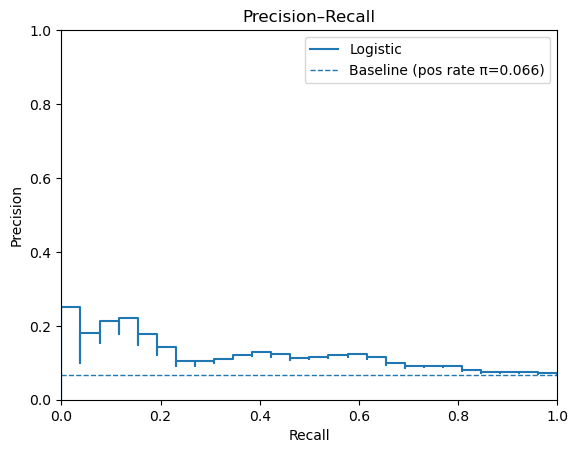

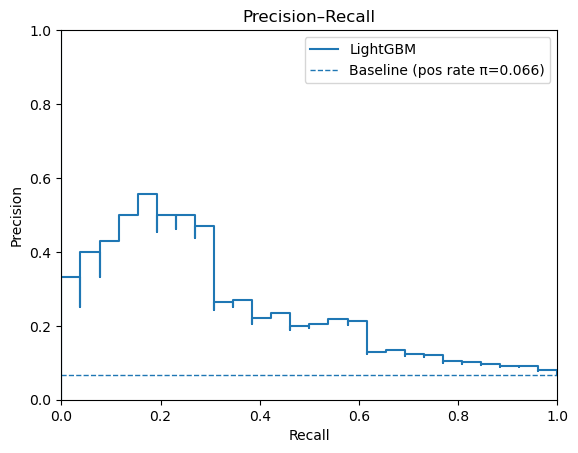

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_pr(y_true, proba, label, baseline=None):
    p, r, _ = precision_recall_curve(y_true, proba)
    base = float(y_true.mean()) if baseline is None else float(baseline)
    plt.figure()
    plt.step(r, p, where="post", label=label)
    plt.axhline(base, linestyle="--", linewidth=1,
                label=f"Baseline (pos rate π={base:.3f})")
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall")
    plt.legend()
    plt.show()

plot_pr(y_te, proba_logit, "Logistic")
plot_pr(y_te, proba_lgbm, "LightGBM")


Dropped all-NaN cols: 0 | zero-variance cols: 116
   Model  ROC_AUC  PR_AUC
   Dummy    0.500   0.066
Logistic    0.652   0.124
LightGBM    0.762   0.254


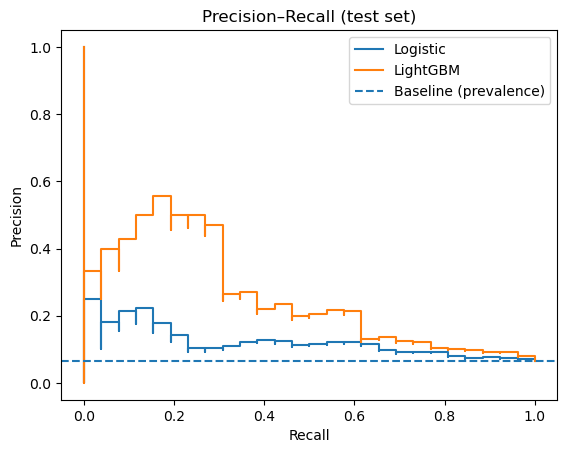


Logistic probability summary:
count    392.000
mean       0.107
std        0.264
min        0.000
25%        0.000
50%        0.000
75%        0.017
max        1.000
dtype: float64

LightGBM probability summary:
count    392.000
mean       0.002
std        0.022
min        0.000
25%        0.000
50%        0.000
75%        0.000
max        0.319
dtype: float64


In [16]:
# 1) What you dropped
print(f"Dropped all-NaN cols: {len(all_nan)} | zero-variance cols: {len(zero_var)}")

# 2) Scores
res = []

# Dummy baseline
dum = DummyClassifier(strategy="most_frequent").fit(X_tr, y_tr)
proba_dum = np.full_like(y_te, fill_value=y_tr.mean(), dtype=float)
res.append(["Dummy", roc_auc_score(y_te, proba_dum), average_precision_score(y_te, proba_dum)])

# Logistic (from earlier)
Log_name="Logistic"
res.append([Log_name, roc_auc_score(y_te, proba_logit), average_precision_score(y_te, proba_logit)])

# Tree model
proba_LGBMtree = proba_lgbm
LGBM_name = "LightGBM"
res.append([LGBM_name, roc_auc_score(y_te, proba_LGBMtree), average_precision_score(y_te, proba_LGBMtree)])

summary = pd.DataFrame(res, columns=["Model","ROC_AUC","PR_AUC"]).round(3)
print(summary.to_string(index=False))

# 3) PR curves with baseline line
plt.figure()
for name, proba in [(Log_name, proba_logit), (LGBM_name,proba_LGBMtree)]:
    p, r, _ = precision_recall_curve(y_te, proba)
    plt.step(r, p, where="post", label=name)
plt.axhline(y=y_tr.mean(), linestyle="--", label="Baseline (prevalence)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (test set)")
plt.legend(); plt.show()

# 4) Probabilities sanity check

print(f"\n{Log_name} probability summary:")
print(pd.Series(proba_logit).describe().round(3))

print(f"\n{LGBM_name} probability summary:")
print(pd.Series(proba_LGBMtree).describe().round(3))



In [17]:
#SESSION 3 (Thresholds and Costs)

# costs: missed bad batch (FN) is 10× worse than unnecessary check (FP)
C_FN, C_FP = 10.0, 1.0

#Splits training set into a subtraining set and validation set to try find best threshold.
X_subtr, X_val, y_subtr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42
)

lgbm = lgb.LGBMClassifier(
    n_estimators=600, learning_rate=0.05, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=-1
)

#Train a tree model on this subteraining data.
lgbm.fit(X_subtr, y_subtr)

proba_val = lgbm.predict_proba(X_val)[:, 1]

In [19]:
from sklearn.metrics import precision_recall_fscore_support
#Function which returns Confusion matrix, the cost, precision, recall of our model for a given threshold.
def metrics_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    tp = int(((pred == 1) & (y_true == 1)).sum())
    fp = int(((pred == 1) & (y_true == 0)).sum())
    tn = int(((pred == 0) & (y_true == 0)).sum())
    fn = int(((pred == 0) & (y_true == 1)).sum())
    cost = C_FN*fn + C_FP*fp
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, pred, average='binary', zero_division=0)
    return {"thr": thr, "tp": tp, "fp": fp, "tn": tn, "fn": fn,
            "precision": prec, "recall": rec, "f1": f1, "cost": cost,
            "pos_rate": pred.mean()}

In [20]:

# use candidate thresholds from the predicted probabilities
# Find threshold that minimizes cost from among them

cands = np.unique(np.round(proba_val, 8))
rows = [metrics_at_threshold(y_val.values, proba_val, thr) for thr in cands]
val_table = pd.DataFrame(rows).sort_values("cost")
best = val_table.iloc[0]
best_thr = float(best["thr"])
best[["thr","precision","recall","f1","cost","pos_rate"]]


thr            0.000007
precision      0.135417
recall         0.650000
f1             0.224138
cost         153.000000
pos_rate       0.326531
Name: 135, dtype: float64

In [21]:
# retrain on all training data, using the threshold from the subtraining data
lgbm_final = lgb.LGBMClassifier(
    n_estimators=600, learning_rate=0.05, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=-1
)
lgbm_final.fit(X_tr, y_tr)

proba_test = lgbm_final.predict_proba(X_te)[:, 1]

# model at chosen threshold
test_best = metrics_at_threshold(y_te.values, proba_test, best_thr)

# model with naive 0.5 threshold (for comparison)
test_05 = metrics_at_threshold(y_te.values, proba_test, 0.5)

# “do nothing” baseline (predict all negatives)
n_pos = int((y_te == 1).sum())
baseline_cost = C_FN * n_pos

# add ranking metrics too (not thresholded)
roc = roc_auc_score(y_te, proba_test)
pr  = average_precision_score(y_te, proba_test)

summary = pd.DataFrame([
    {"model":"LightGBM @ best_thr", **{k:test_best[k] for k in ["thr","precision","recall","f1","cost","pos_rate","tp","fp","fn","tn"]}},
    {"model":"LightGBM @ 0.50",    **{k:test_05[k]   for k in ["thr","precision","recall","f1","cost","pos_rate","tp","fp","fn","tn"]}},
    {"model":"Baseline (all 0)",   "thr":np.nan, "precision":0.0, "recall":0.0, "f1":0.0, "cost":baseline_cost, "pos_rate":0.0,
                                    "tp":0, "fp":0, "fn":n_pos, "tn":int((y_te==0).sum())}
]).round(3)

print(f"Ranking metrics (independent of threshold)  ROC-AUC={roc:.3f}  PR-AUC={pr:.3f}")
summary

Ranking metrics (independent of threshold)  ROC-AUC=0.762  PR-AUC=0.254


,model,thr,precision,recall,f1,cost,pos_rate,tp,fp,fn,tn
0,LightGBM @ best_thr,0.0,0.122,0.692,0.208,209.0,0.375,18,129,8,237
1,LightGBM @ 0.50,0.5,0.000,0.000,0.000,260.0,0.000,0,0,26,366
2,Baseline (all 0),NaN,0.000,0.000,0.000,260.0,0.000,0,0,26,366


C:\Users\conor\miniconda3\envs\dsproj\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


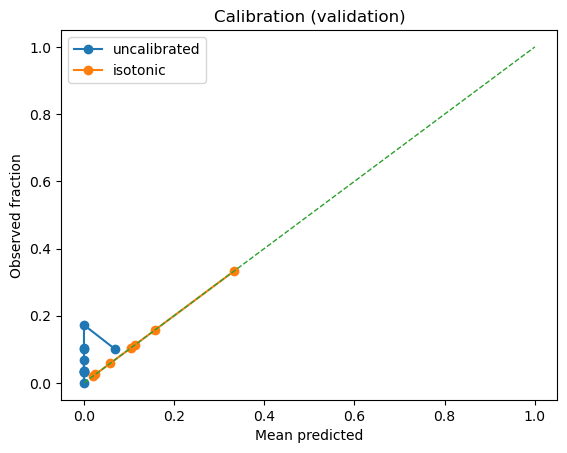

Brier (uncal vs cal): 0.0698 0.0603
ROC-AUC / PR-AUC (uncal): 0.686 0.137
ROC-AUC / PR-AUC (cal):   0.722 0.143


In [22]:
#SESSION 4 
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# lgbm is the model trained on X_trn,y_trn (NOT on all X_tr)
# 1) Calibrate on the validation set
cal = CalibratedClassifierCV(lgbm, method="isotonic", cv="prefit")
cal.fit(X_val, y_val)

# 2) Check calibration quality on validation
proba_val_unc = lgbm.predict_proba(X_val)[:,1]
proba_val_cal = cal.predict_proba(X_val)[:,1]

def calib_plot(y_true, p_unc, p_cal):
    for p, lbl in [(p_unc,"uncalibrated"), (p_cal,"isotonic")]:
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=10, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", label=lbl)
    plt.plot([0,1],[0,1],"--", linewidth=1)
    plt.xlabel("Mean predicted"); plt.ylabel("Observed fraction"); plt.title("Calibration (validation)")
    plt.legend(); plt.show()

calib_plot(y_val, proba_val_unc, proba_val_cal)
print("Brier (uncal vs cal):", 
      round(brier_score_loss(y_val, proba_val_unc),4),
      round(brier_score_loss(y_val, proba_val_cal),4))

print("ROC-AUC / PR-AUC (uncal):", 
      round(roc_auc_score(y_val, proba_val_unc),3), 
      round(average_precision_score(y_val, proba_val_unc),3))

print("ROC-AUC / PR-AUC (cal):  ", 
      round(roc_auc_score(y_val, proba_val_cal),3), 
      round(average_precision_score(y_val, proba_val_cal),3))

In [23]:
cands = np.unique(np.round(proba_val_cal, 6))
rows = [metrics_at_threshold(y_val.values, proba_val_cal, thr) for thr in cands]
val_cal_table = pd.DataFrame(rows).sort_values("cost")
best_cal = val_cal_table.iloc[0]
best_thr_cal = float(best_cal["thr"])
best_cal[["thr","precision","recall","f1","cost","pos_rate"]]

thr            0.058824
precision      0.136842
recall         0.650000
f1             0.226087
cost         152.000000
pos_rate       0.323129
Name: 3, dtype: float64

In [24]:
proba_test_cal = cal.predict_proba(X_te)[:,1]

test_best_cal = metrics_at_threshold(y_te.values, proba_test_cal, best_thr_cal)
test_05_cal  = metrics_at_threshold(y_te.values, proba_test_cal, 0.5)

baseline_cost = C_FN * int((y_te == 1).sum())
roc = roc_auc_score(y_te, proba_test_cal)
pr  = average_precision_score(y_te, proba_test_cal)

summary_cal = pd.DataFrame([
    {"model":"Calibrated @ best_thr", **{k:test_best_cal[k] for k in ["thr","precision","recall","f1","cost","pos_rate","tp","fp","fn","tn"]}},
    {"model":"Calibrated @ 0.50",    **{k:test_05_cal[k]  for k in ["thr","precision","recall","f1","cost","pos_rate","tp","fp","fn","tn"]}},
    {"model":"Baseline (all 0)",     "thr":np.nan, "precision":0.0, "recall":0.0, "f1":0.0, "cost":baseline_cost,
                                      "pos_rate":0.0, "tp":0, "fp":0, "fn":int((y_te==1).sum()), "tn":int((y_te==0).sum())}
]).round(3)

print(f"Test (calibrated)  ROC-AUC={roc:.3f}  PR-AUC={pr:.3f}")
summary_cal


Test (calibrated)  ROC-AUC=0.737  PR-AUC=0.147


,model,thr,precision,recall,f1,cost,pos_rate,tp,fp,fn,tn
0,Calibrated @ best_thr,0.059,0.134,0.731,0.226,193.0,0.362,19,123,7,243
1,Calibrated @ 0.50,0.500,0.000,0.000,0.000,260.0,0.000,0,0,26,366
2,Baseline (all 0),NaN,0.000,0.000,0.000,260.0,0.000,0,0,26,366


In [25]:
import shap

# fit on the full training set for feature importance storytelling
lgbm_full = lgb.LGBMClassifier(
    n_estimators=600, learning_rate=0.05, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=-1
).fit(X_tr, y_tr)

# SHAP values (sample to speed up)
X_sample = X_te.sample(n=min(300, len(X_te)), random_state=42)
explainer = shap.TreeExplainer(lgbm_full)
shap_vals = explainer.shap_values(X_sample)  # for binary, index 1 are positives
sv = shap_vals[1] if isinstance(shap_vals, list) else shap_vals

# top features by mean |SHAP|
top = pd.Series(np.abs(sv).mean(axis=0), index=X_sample.columns).sort_values(ascending=False).head(15)
top

C:\Users\conor\miniconda3\envs\dsproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\conor\miniconda3\envs\dsproj\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


f59     0.510406
f103    0.471945
f33     0.436825
f21     0.355181
f577    0.338622
f31     0.308618
f477    0.275709
f213    0.258115
f81     0.250797
f488    0.224059
f86     0.218718
f75     0.213734
f130    0.206193
f587    0.196697
f333    0.193184
dtype: float64

In [26]:
#Session 5 (Setting up a drift alarm system)
lambda_ = 0.2
k = 3  # ~3-sigma equivalent
# Time-order each split by original row index
X_tr_ordered = X_tr.sort_index(kind="mergesort")
y_tr_ordered = y_tr.reindex(X_tr_ordered.index)

X_te_ordered = X_te.sort_index(kind="mergesort")
y_te_ordered = y_te.reindex(X_te_ordered.index)


feat_list = top.index.tolist()[:10]  # your SHAP-ranked features

stats = []
for f in feat_list:
    mu = X_tr_ordered[f].mean()
    sd = X_tr_ordered[f].std(ddof=1)
    stats.append({"feature": f, "mu": mu, "sd": sd})
stats = pd.DataFrame(stats).set_index("feature")
stats.head()


,mu,sd
feature,,
f59,3.062713,8.758854
f103,-0.009777,0.003020
f33,8.964803,1.339159
f21,-5615.909574,635.536877
f577,16.524425,12.120642


In [28]:
def ewma(series, lam=lambda_):
    z = []
    prev = series.iloc[0]
    for x in series:
        prev = lam * x + (1 - lam) * prev
        z.append(prev)
    return pd.Series(z, index=series.index)

def ewma_limits(sd, lam=lambda_, k=k):
    # steady-state sigma for EWMA
    sigma_ewma = np.sqrt(lam/(2 - lam)) * sd
    return k * sigma_ewma


In [29]:
alarms = []
for f in feat_list:
    mu, sd = stats.loc[f, ["mu","sd"]]
    z = ewma(X_te_ordered[f].fillna(mu))  # simple impute to training mean for charting
    lim = ewma_limits(sd)
    up = mu + lim
    lo = mu - lim
    alarm_idx = (z > up) | (z < lo)
    alarms.append(pd.DataFrame({
        "feature": f,
        "z": z.values, "upper": up, "lower": lo, "alarm": alarm_idx.values
    }))

alarms_df = pd.concat(alarms, axis=0, ignore_index=True)
alarms_df["alarm"].mean()  # fraction of points alarming


np.float64(0.049489795918367344)

In [22]:
def consecutive(seq):
    c = pd.Series(seq).astype(int)
    return (c.rolling(2).sum() == 2)                # two trues in a row

alerts = []
for f in feat_list:
    df = alarms_df[alarms_df["feature"] == f].copy()
    df["alarm2"] = consecutive(df["alarm"])
    alerts.append(df[["feature","alarm2"]])

alert_matrix = pd.concat(alerts, axis=0)
by_batch = alert_matrix.groupby(alert_matrix.index)["alarm2"].sum()
final_alert = (by_batch >= 2)  
# at least 2 features alarming
final_alert.mean()  # workload of drift alerts


np.float64(0.0)

In [30]:
import json, joblib

ART = Path("artifacts"); ART.mkdir(exist_ok=True)

# You already have these from Session 4/5:
# cal  -> CalibratedClassifierCV fitted on lgbm (prefit)
# lgbm_full -> LGBMClassifier fitted on full training data (for SHAP/feature names)
# best_thr_cal -> your chosen calibrated threshold (float)
# top -> pd.Series of top SHAP features (index = names)
# stats -> DataFrame with baseline mu/sd for watched features (index=feature, cols=["mu","sd"])

joblib.dump(cal, ART/"calibrated_model.joblib")
joblib.dump(lgbm_full, ART/"lgbm_full.joblib")

with open(ART/"config.json", "w") as f:
    json.dump({
        "threshold": float(best_thr_cal),
        "costs": {"FN": 10.0, "FP": 1.0},
        "watched_features": list(top.index[:10]),
    }, f, indent=2)

# Save baseline means/stds for drift
stats.loc[list(top.index[:10]), ["mu","sd"]].to_csv(ART/"drift_baseline.csv")


In [28]:
import json
import numpy as np
import pandas as pd
import streamlit as st

from pathlib import Path

# ---------- Load artifacts ----------
ART = Path("artifacts")
cal = joblib.load(ART/"calibrated_model.joblib")
lgbm_full = joblib.load(ART/"lgbm_full.joblib")

with open(ART/"config.json") as f:
    cfg = json.load(f)

thr_default = float(cfg["threshold"])
C_FN, C_FP = cfg["costs"]["FN"], cfg["costs"]["FP"]
watched = cfg["watched_features"]
baseline = pd.read_csv(ART/"drift_baseline.csv").set_index("feature")

# ---------- Helpers ----------
def expected_cost(y_hat, thr, c_fn=C_FN, c_fp=C_FP, y_true=None):
    pred = (y_hat >= thr).astype(int)
    fp = int(pred.sum())  # without labels we treat all flagged as workload; for expected cost we need y_true
    if y_true is None:
        return {"workload": pred.mean(), "tp": np.nan, "fp": fp, "fn": np.nan, "tn": np.nan, "cost": c_fp*fp}
    tp = int(((pred==1) & (y_true==1)).sum())
    fn = int(((pred==0) & (y_true==1)).sum())
    tn = int(((pred==0) & (y_true==0)).sum())
    cost = c_fn*fn + c_fp*fp
    return {"workload": pred.mean(), "tp": tp, "fp": fp, "fn": fn, "tn": tn, "cost": cost}

def ewma(x, lam=0.2):
    z = []
    prev = x.iloc[0]
    for v in x:
        prev = lam*v + (1-lam)*prev
        z.append(prev)
    return pd.Series(z, index=x.index)

def ewma_limits(sd, lam=0.2, k=3.0):
    return k * np.sqrt(lam/(2-lam)) * sd

def drift_flags(df):
    # simple per-feature EWMA vs fixed limits; expect rows in time order
    alerts = {}
    for f in watched:
        if f not in df.columns: 
            alerts[f] = {"frac_alarm": np.nan}
            continue
        mu, sd = baseline.loc[f, ["mu","sd"]]
        z = ewma(df[f].fillna(mu))
        lim = ewma_limits(sd)
        alarm = (z > mu+lim) | (z < mu-lim)
        # throttle: need 2 in a row
        alarm2 = alarm & alarm.shift(1, fill_value=False)
        alerts[f] = {"frac_alarm": float(alarm2.mean())}
    # require ≥2 features alarming at a row to count a final alert
    A = pd.DataFrame({f: pd.Series(dtype=bool) for f in watched})
    for f in watched:
        if f in df.columns:
            mu, sd = baseline.loc[f, ["mu","sd"]]
            z = ewma(df[f].fillna(mu))
            lim = ewma_limits(sd)
            alarm = (z > mu+lim) | (z < mu-lim)
            A[f] = (alarm & alarm.shift(1, fill_value=False)).reindex(df.index, fill_value=False)
    final_alert = (A.sum(axis=1) >= 2)
    return alerts, float(final_alert.mean())

# ---------- UI ----------
st.title("Quality Risk & Drift Monitor")

st.sidebar.header("Settings")
thr = st.sidebar.slider("Decision threshold (calibrated)", min_value=0.0, max_value=0.5, value=float(thr_default), step=0.005)
c_fn = st.sidebar.number_input("Cost of FN (missed bad batch)", value=float(C_FN), min_value=0.0)
c_fp = st.sidebar.number_input("Cost of FP (extra review)", value=float(C_FP), min_value=0.0)

st.write("Upload a CSV with the same columns as training (feature names must match).")
file = st.file_uploader("CSV file", type=["csv"])

if file:
    df = pd.read_csv(file)
    missing_cols = [c for c in lgbm_full.feature_name_ if c not in df.columns]
    extra_cols = [c for c in df.columns if c not in lgbm_full.feature_name_]

    if missing_cols:
        st.error(f"Missing {len(missing_cols)} expected columns (showing first 10): {missing_cols[:10]}")
        st.stop()

    X = df[lgbm_full.feature_name_].copy()
    proba = cal.predict_proba(X)[:,1]

    # headline metrics (no labels case)
    res = expected_cost(proba, thr, c_fn, c_fp, y_true=df[df.columns[-1]] if "label" in df.columns else None)

    st.subheader("Headline")
    col1, col2, col3 = st.columns(3)
    col1.metric("Flagged workload", f"{res['workload']*100:.1f}%")
    col2.metric("Threshold", f"{thr:.3f}")
    col3.metric("Expected cost", f"{res['cost']:.1f}")

    # top risky rows
    st.subheader("Top risk rows")
    topn = min(20, len(df))
    idx = np.argsort(-proba)[:topn]
    tbl = pd.DataFrame({"row_idx": idx, "risk_prob": proba[idx]})
    st.dataframe(tbl, use_container_width=True)

    # drift
    st.subheader("Drift check (EWMA on watched features)")
    alerts, final_rate = drift_flags(X)
    st.write(f"Final drift alert rate (≥2 features, 2 consecutive): **{final_rate*100:.1f}%**")
    drift_tbl = pd.DataFrame(alerts).T.sort_values("frac_alarm", ascending=False)
    st.dataframe(drift_tbl, use_container_width=True)

    # extras
    if extra_cols:
        st.info(f"Ignored {len(extra_cols)} extra columns not seen in training (first 10): {extra_cols[:10]}")
else:
    st.info("Waiting for a CSV…")


2025-08-08 10:53:52.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.381 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.383 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 10:53:52.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [32]:
# --- params ---
n_rows   = 50                           # how many rows you want in the sample file
out_file = Path("sample_features.csv")  # where to save it

# --- grab a sample from whatever feature frame you have ----
# If you’ve kept X_te / X_tr etc. in memory:
sample = X_te.sample(n=n_rows, random_state=42).copy()

# OPTIONAL: include the label column so the app can compute exact cost
# sample["label"] = y_te.loc[sample.index].values   # uncomment if you want labels

# --- write ---
sample.to_csv(out_file, index=False)
print(f"Wrote {n_rows} rows to {out_file.resolve()}")

Wrote 50 rows to C:\Users\conor\Projects\quality-risk\notebooks\sample_features.csv
